
<h2 align="center">Predict Employee Churn with Decision Trees and Random Forests</h2>

### Task 1: Import Libraries
---

In [4]:
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
import pandas_profiling
plt.style.use("ggplot")
warnings.simplefilter("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
plt.rcParams['figure.figsize'] = (12,8)

### Task 2: Exploratory Data Analysis
---

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
hr=pd.read_csv('/content/drive/My Drive/Employee rentention prediction/employee_data.csv')
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [8]:
hr.profile_report(title='Data Report')

# pandas_profiling.describe_df(hr)
# html_str_output = pandas_profiling.ProfileReport(hr)

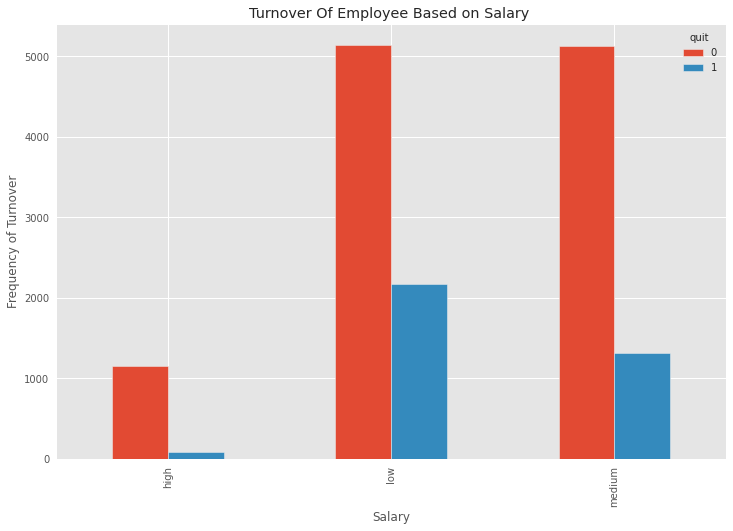

In [9]:
pd.crosstab(hr.salary,hr.quit).plot(kind='bar')
plt.title('Turnover Of Employee Based on Salary ')
plt.xlabel('Salary')
plt.ylabel('Frequency of Turnover')
plt.show()

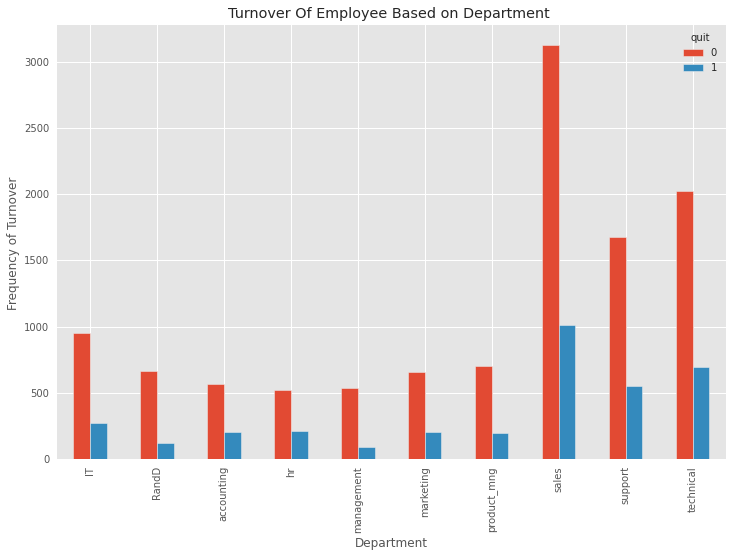

In [10]:
pd.crosstab(hr.department,hr.quit).plot(kind='bar')
plt.title('Turnover Of Employee Based on Department ')
plt.xlabel('Department')
plt.ylabel('Frequency of Turnover ')
plt.show()

### Task 3: Encode Categorical Features
---

In [0]:
cat_var = ['salary','department']
for var in cat_var:
  cat_list = pd.get_dummies(hr[var],prefix=var)
  hr=hr.join(cat_list)

In [11]:
hr.head()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary,salary_high,salary_low,salary_medium,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,sales,medium,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,sales,low,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,0,1,0,0,0,0,0,0,0,0,1,0,0


In [0]:
hr.drop(columns=['salary','department'], axis=1,inplace=True)

In [13]:
hr.head()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,salary_high,salary_low,salary_medium,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0


### Task 4: Visualize Class Imbalance
---

In [0]:
from yellowbrick.target import ClassBalance
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12,8)

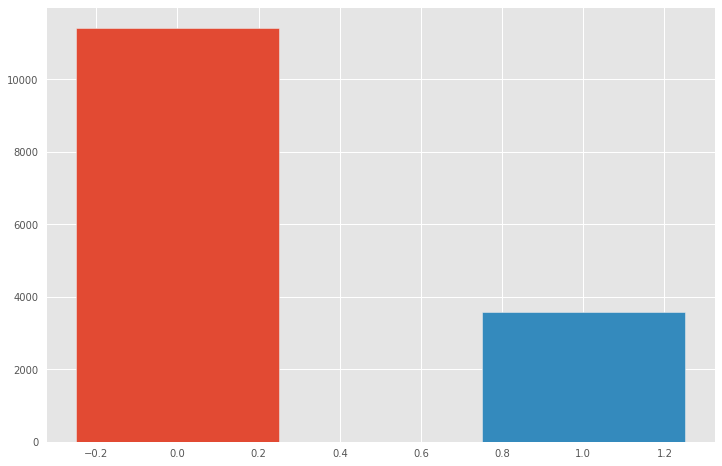

In [15]:
visualizer=ClassBalance()
visualizer.fit(hr.quit)        # Fit the data to the visualizer
visualizer.labels=['stayed','quit']


### Task 5: Create Training and Test Sets
---

In [0]:
X=hr.loc[:, hr.columns != 'quit']
Y=hr.quit

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,Y,random_state=0,test_size=0.2,stratify=Y)

### Task 6 & 7: Build an Interactive Decision Tree Classifier
---

Supervised learning: 
- The inputs are random variables $X = X_1, ..., X_p$;
- The output is a random variable $Y.$

- Data is a finite set $$\mathbb{L}=\{(x_i,y_i)|i=0, ..., N-1\}$$
where $x_i \in X = X_1 \times ... \times X_p$ and $y_i \in y$ are randomly drawn from $P_{X,Y}.$

E.g., $(x_i,y_i)=((\text{salary = low, department = sales, ...}),\text{quit = 1})$

- The goal is to find a model $\varphi_\mathbb{L}: X \mapsto y$ minimizing $$\text{Err}(\varphi_\mathbb{L}) = \mathbb{E}_{X,Y}\{L(Y, \varphi_\mathbb{L}(X))\}.$$

About:
 
 - Decision trees are non-parametric models which can model arbitrarily complex relations between inputs and outputs, without any a priori assumption
 
- Decision trees handle numeric and categorical variables

- They implement feature selection, making them robust to noisy features (to an extent)

- Robust to outliers or errors in labels

- Easily interpretable by even non-ML practioners.

#### Decision trees: partitioning the feature space:

![partition](assets/images/partition-feature-space.png)

- Decision trees generally have low bias but have high variance.
- We will solve the high variance problem in Task 8.

In [0]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

In [19]:
@interact
def plot_tree(crit=['gini','entropy'],split=['best','random'],depth=IntSlider(min=1,max=30,value=2, continuous_update=False),min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
  estimator=DecisionTreeClassifier(random_state=0,criterion=crit,splitter=split,max_depth=depth,min_samples_split=min_split,min_samples_leaf=min_leaf)
  estimator.fit(X_train,y_train)
  print('Decision Tree Training Accuraccy {:.3f}'.format(accuracy_score(y_train,estimator.predict(X_train))))
  print('Decision Tree Validation Accuracy {:.3f}'.format(accuracy_score(y_test,estimator.predict(X_test))))
 
  graph = Source(tree.export_graphviz(estimator,out_file=None,feature_names=X_train.columns,class_names=['stayed','quit'],filled=True))
  display(Image(data=graph.pipe(format='png')))
  return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Task 8: Build an Interactive Random Forest Classifier
---

Although randomization increases bias, it is possible to get a reduction in variance of the ensemble. Random forests are one of the most robust machine learning algorithms for a variety of problems.

- Randomization and averaging lead to a reduction in variance and improve accuracy
- The implementations are parallelizable
- Memory consumption and training time can be reduced by bootstrapping
- Sampling features and not solely sampling examples is crucial to improving accuracy

In [20]:
@interact
def plot_tree_rf(crit=['gini','entropy'],
                 bootstrap=['True','False'],
                 depth=IntSlider(min=1,max=20,value=3, continuous_update=False),
                 forests=IntSlider(min=1,max=200,value=100,continuous_update=False),
                 min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
                 min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
  estimator = RandomForestClassifier(
        random_state=1,
        criterion=crit,
        bootstrap=bootstrap,
        n_estimators=forests,
        max_depth=depth,
        min_samples_split=min_split,
        min_samples_leaf=min_leaf,
        n_jobs=-1,
        verbose=False)
  estimator.fit(X_train,y_train)
  print('Random Forest Training Accuraccy {:.3f}'.format(accuracy_score(y_train,estimator.predict(X_train))))
  print('Random Forest Validation Accuracy {:.3f}'.format(accuracy_score(y_test,estimator.predict(X_test))))
  num_tree = estimator.estimators_[0]
  print('Visualizing Tree: ')
  graph = Source(tree.export_graphviz(num_tree,out_file=None,feature_names=X_train.columns,class_names=['stayed','quit'],filled=True))
  display(Image(data=graph.pipe(format='png')))
  return estimator
    
    

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Task 9: Feature Importance and Evaluation Metrics
---

In [0]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

FeatureImportances(absolute=False,
                   ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ccf1f11d0>,
                   colormap=None, colors=None, is_fitted='auto', labels=None,
                   model=None, relative=True, stack=False, xlabel=None)

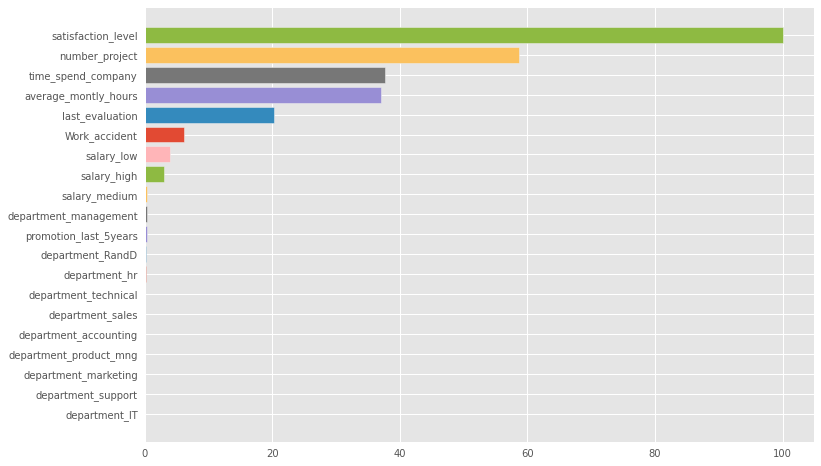

In [22]:
rf = RandomForestClassifier(bootstrap='True', ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1,
                       verbose=False, warm_start=False)
visualize = FeatureImportances(rf)
visualize.fit(X_train,y_train)

FeatureImportances(absolute=False,
                   ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ccf584080>,
                   colormap=None, colors=None, is_fitted='auto', labels=None,
                   model=None, relative=True, stack=False, xlabel=None)

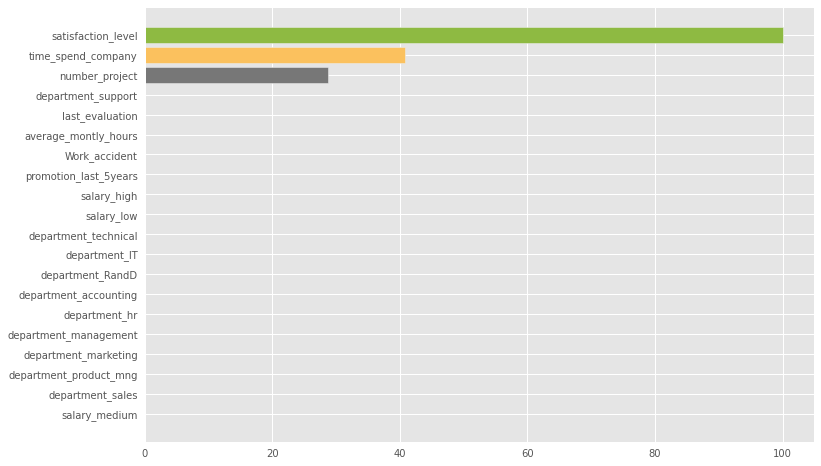

In [23]:
dtree = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
visualize = FeatureImportances(dtree)
visualize.fit(X_train,y_train)

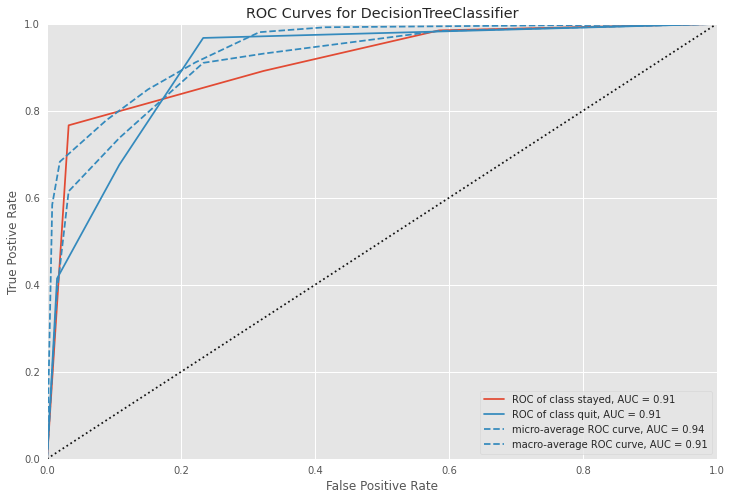

In [24]:
from yellowbrick.classifier import ROCAUC

visualize=ROCAUC(dtree,classes=['stayed','quit'])
visualize.fit(X_train,y_train)
visualize.score(X_test,y_test)
visualize.poof()

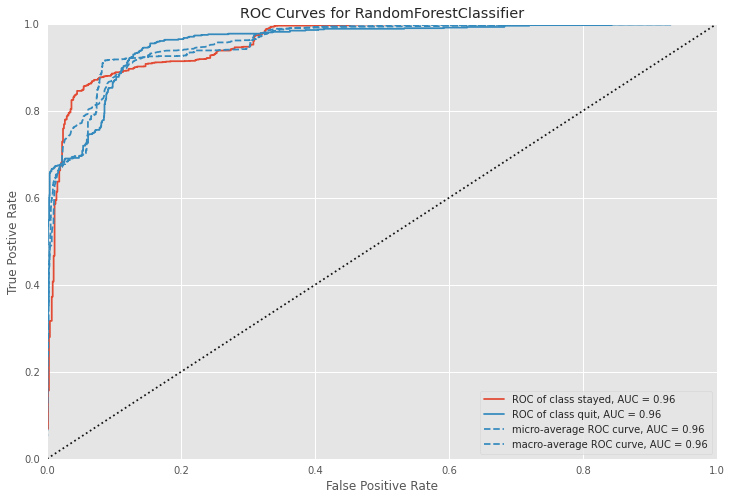

In [25]:
from yellowbrick.classifier import ROCAUC

visualize=ROCAUC(rf,classes=['stayed','quit'])
visualize.fit(X_train,y_train)
visualize.score(X_test,y_test)
visualize.poof()